In [55]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import time
import pandas as pd

In [56]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 6, 5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)
        x = F.max_pool2d(F.relu(x), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


(600, 800)
(600, 800)


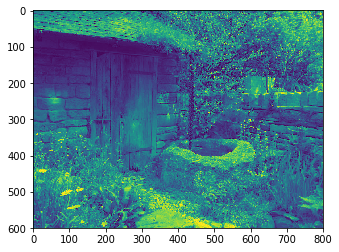

In [57]:
img = cv2.imread('details.jpg',0)

def crop(img, lu, rb):
    return img[lu[0]:rb[0], lu[1]:rb[1]]
    
def resize(img, h, w):
    return cv2.resize(img, (w, h)) 

def random_crop(sample, m=40):
    h = sample.shape[1]
    w = sample.shape[0]
    mw = m
    mh = m
    
    l = random.randint(0, w-mw)
    r = random.randint(l+mw, w)
    
    u = random.randint(0, h-mh)
    b = random.randint(u+mh, h)
    
    return crop(sample, (l, u), (r, b)), ((l, u), (r, b))
    
def display_boxes(img, boxL, boxT):
#     print(boxL)
#     print(boxT)
    
    t = cv2.rectangle(img,boxL[0],boxL[1],(255,0,0), 1)
    t = cv2.rectangle(t,boxT[0],boxT[1],(0,255,0), 2)
    cv2.imshow('image',resize(t, 640, 640))

def display(img, L, T):
    h = img.shape[0]
    w = img.shape[1]
    
    boxL = (int(L[0] * h), int(L[1] * w)), (int(L[2] * h), int(L[3] * w))
    boxT = (int(T[0] * h), int(T[1] * w)), (int(T[2] * h), int(T[3] * w))
    display_boxes(img, boxL, boxT)
    
    
# img = crop(img, (20, 20), (40, 100))
# img = resize(img, 20, 40)
print(img.shape)
# img, _ = random_crop(img)
print(img.shape)
plt.imshow(img)

In [74]:
caseNo = 10000
sample = img
sad = 128
obd = 32
fd = 32
scaling_factor = 1

losses = []
cv2.destroyAllWindows()

optimizer = optim.Adam(net.parameters(), lr = 0.0005)

loss = nn.MSELoss()

for i in tqdm(range(caseNo)):
    search_area, _ = random_crop(sample, sad)
    search_area = resize(search_area, sad, sad)
    obj, box = random_crop(search_area, obd)

    
    labels = box[0][0] / sad, box[0][1] / sad, box[1][0] / sad, box[1][1] / sad
#     plt.imshow(obj)
#     plt.imshow(cv2.rectangle(search_area,box[0],box[1],(255,0,0), 1))
    
    X = np.dstack([resize(search_area, fd, fd), resize(obj, fd, fd)]).transpose((2, 0, 1))
#     X = np.dstack([resize(search_area, fd, fd), resize(obj, fd, fd)])
#     print(X.shape)
    
    X = torch.tensor(([X/255])).float()
    X = torch.autograd.Variable(X, requires_grad=True)
    Y = net(X) * scaling_factor
#     torch.autograd.Variable(torch.randn((3,5)), requires_grad=True)
#     T = torch.autograd.Variable(torch.tensor(labels), requires_grad=False)
#     T = torch.autograd.Variable(torch.tensor(labels, requires_grad=False), requires_grad=False)
    T = torch.tensor([labels], requires_grad=False)
    
    l = loss(Y, T)

    losses.append(l)
    if i % 500 == 0:
#         torch.save(net.state_dict(), "net")

#         print(i, Y.data.numpy()[0], T.data.numpy()[0])
        display(search_area, Y.data.numpy()[0], T.data.numpy()[0])
        cv2.waitKey(1)
#         time.sleep(0.5)
    
    l.backward()
    optimizer.step()
#     print(X.shape)

cv2.destroyAllWindows()
# pd.Series(losses).plot()

100%|██████████| 10000/10000 [00:25<00:00, 387.21it/s]


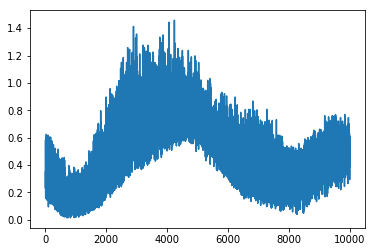

In [75]:
t = map(lambda x:float(x.data.numpy()), losses)
pd.Series(t).plot()

999 [ 0.02457903  0.05061942 -0.08223155  0.10660891] [0.203125 0.46875  0.9375   0.984375]
